# Churn Prediction for Deposits


<h3><span style="color: #117d30;"> Using RandomForest Classifier </span></h3>


## Overview
# 


MMLSpark is an ecosystem of tools aimed towards expanding the distributed computing framework Apache Spark in several new directions. MMLSpark adds many deep learning and data science tools to the Spark ecosystem, including seamless integration of Spark Machine Learning pipelines with Microsoft Cognitive Toolkit (CNTK), LightGBM, RandomForestClassifiers and OpenCV. These tools enable powerful and highly-scalable predictive and analytical models for a variety of datasources.

This notebook presents Data Science Workflow for Bank Marketing Dataset Azure using MMLSpark. This is a direct marketing campaign's (phone calls) dataset of a Portuguese banking institution. The goal is to predict Customer Acquisition Churn, that is whether a customer will subscribe the term deposit, based on the campaign data.

## Set-up

Defining storage, file path and file name for raw input as well as processed output


# Disclaimer
By accessing this code, you acknowledge the code is made available for presentation and demonstration purposes only and that the code (1) is not subject to SOC 1 and SOC 2 compliance audits, and (2) is not designed or intended to be a substitute for the professional advice, diagnosis, treatment, or judgment of a certified financial services professional. Do not use this code to replace, substitute, or provide professional financial advice, or judgement. You are solely responsible for ensuring the regulatory, legal, and/or contractual compliance of any use of the code, including obtaining any authorizations or consents, and any solution you choose to build that incorporates this code in whole or in part. © 2020 Microsoft Corporation. All rights reserved

### Importing Libraries

In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import pandas as pd

StatementMeta(SparkChurn, 80, 2, Finished, Available)

### Create Connection and Make it a Data Frame

In [3]:
from azure.storage.blob import ContainerClient, BlobClient
import pandas as pd
from io import BytesIO

CONNECTIONSTRING = 'DefaultEndpointsProtocol=https;AccountName=#STORAGE_ACCOUNT_NAME#;AccountKey=#STORAGE_ACCOUNT_KEY#;EndpointSuffix=core.windows.net'
CONTAINER_NAME = 'retail-banking-customer-churn'

BLOBNAME = 'retail_banking_customer_churn_data.csv'
blob = BlobClient.from_connection_string(conn_str=CONNECTIONSTRING, container_name=CONTAINER_NAME, blob_name=BLOBNAME)
blob_data = blob.download_blob()
BytesIO(blob_data.content_as_bytes())
churn_df = pd.read_csv(BytesIO(blob_data.content_as_bytes()))

StatementMeta(SparkChurn, 80, 3, Finished, Available)

### Data Frame

In [4]:
churn_df

StatementMeta(SparkChurn, 80, 4, Finished, Available)

       age          job  marital  ... euribor3m nr.employed    y
0       56    housemaid  married  ...     4.857      5191.0   no
1       57     services  married  ...     4.857      5191.0   no
2       37     services  married  ...     4.857      5191.0   no
3       40       admin.  married  ...     4.857      5191.0   no
4       56     services  married  ...     4.857      5191.0   no
...    ...          ...      ...  ...       ...         ...  ...
41183   73      retired  married  ...     1.028      4963.6  yes
41184   46  blue-collar  married  ...     1.028      4963.6   no
41185   56      retired  married  ...     1.028      4963.6   no
41186   44   technician  married  ...     1.028      4963.6  yes
41187   74      retired  married  ...     1.028      4963.6   no

[41188 rows x 21 columns]

### Convert to a Pyspark Data Frame

In [5]:
spark_churn_df=spark.createDataFrame(churn_df) 
spark_churn_df.printSchema()
spark_churn_df.show(5)

StatementMeta(SparkChurn, 80, 5, Finished, Available)

root
 |-- age: long (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: long (nullable = true)
 |-- campaign: long (nullable = true)
 |-- pdays: long (nullable = true)
 |-- previous: long (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+-

### Exploratory Data Analysis

In [6]:
# View the Pyspark Data Frame

display(spark_churn_df)

StatementMeta(SparkChurn, 80, 6, Finished, Available)

SynapseWidget(Synapse.DataFrame, 9434e572-49a5-4697-8d42-0749fb6d279f)

Find dimensionality of a pyspark data frame

In [7]:
# Function to print shape of dataframe
def df_shape(spark_churn_df):
    return (spark_churn_df.count(), len(spark_churn_df.columns))

print("shape of Dataset",df_shape(spark_churn_df))

StatementMeta(SparkChurn, 80, 7, Finished, Available)

shape of Dataset (41188, 21)

In [8]:
# Summary statistics

display(spark_churn_df.summary())

StatementMeta(SparkChurn, 80, 8, Finished, Available)

SynapseWidget(Synapse.DataFrame, 58983e76-0b63-4c2d-99fb-df95d4c119fb)

### Visualizing the Churn paired with Data

Using pyspark to attmept the visualization of our data

In [9]:
import pyspark.sql.functions as F
display(spark_churn_df.where(F.col("y").isNotNull()).groupBy('y').count().sort('count', ascending = False))


StatementMeta(SparkChurn, 80, 9, Finished, Available)

SynapseWidget(Synapse.DataFrame, 1f9424b9-7310-44d6-ab28-bbd34be1a241)

And onto the more appropiate and flexible libraries for data visualization

In [10]:
spark_churn_df = spark_churn_df.withColumnRenamed('y','Churn')
spark_churn_df = spark_churn_df.withColumnRenamed('emp.var.rate','emp_var_rate')
spark_churn_df = spark_churn_df.withColumnRenamed('cons.price.idx','cons_price_idx')
spark_churn_df = spark_churn_df.withColumnRenamed('cons.conf.idx','cons_conf_idx')
spark_churn_df = spark_churn_df.withColumnRenamed('nr.employed','nr_employed')

StatementMeta(SparkChurn, 80, 10, Finished, Available)

## Job and Churn

StatementMeta(SparkChurn, 80, 11, Finished, Available)

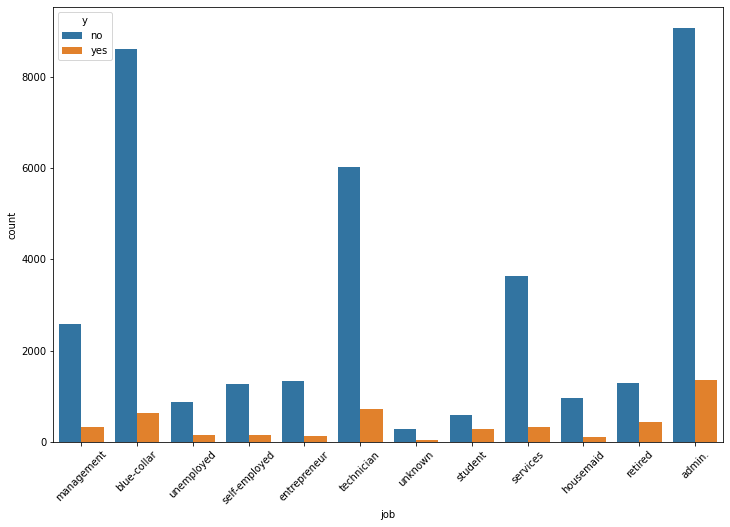

In [11]:
class_order = list(set(churn_df['job'].values))
hue_order = list(set(churn_df['y'].values))

plt.figure(figsize=(12,8))
chart = sns.countplot(data=churn_df,x='job',order = class_order, hue = 'y')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

Looking at the visualization one could come to the conclusion that management would come forward as the profession where the churn rate would be the highest and a blue-collar and admin professions where churn rate would be the lowest.

## Marital & Churn

StatementMeta(SparkChurn, 80, 12, Finished, Available)

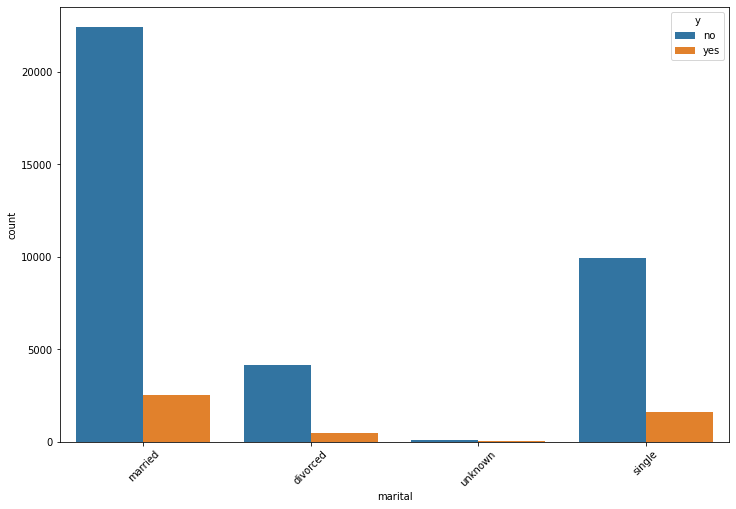

In [12]:
class_order = list(set(churn_df['marital'].values))
hue_order = list(set(churn_df['y'].values))

plt.figure(figsize=(12,8))
chart = sns.countplot(data=churn_df,x='marital',order = class_order, hue = 'y')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

Married people have the highest amount of skewness by far in terms of count, whereas the churn rate is not very different between divorced and single customers.

## Churn and Contact

StatementMeta(SparkChurn, 80, 13, Finished, Available)

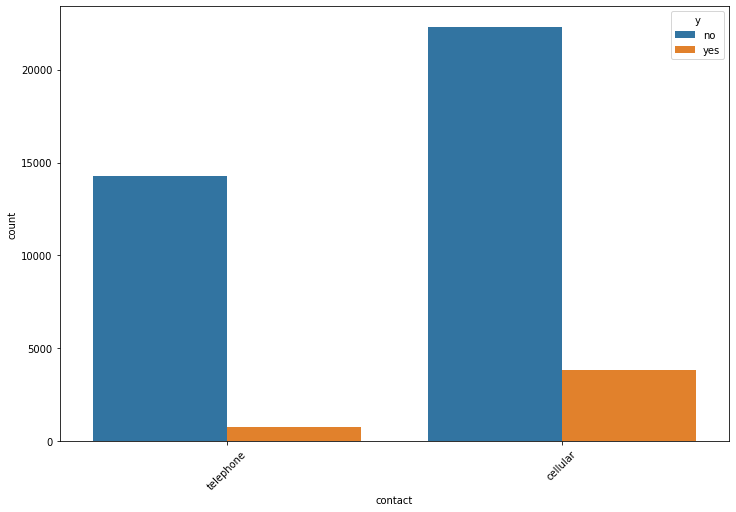

In [13]:
class_order = list(set(churn_df['contact'].values))
hue_order = list(set(churn_df['y'].values))

plt.figure(figsize=(12,8))
chart = sns.countplot(data=churn_df,x='contact',order = class_order, hue = 'y')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

The churn and the method of contact also seems to have large disparity between them, with far more churning of clients than not whether by cellphone device or telephone

## Rename the columns

In [14]:
spark_churn_df = spark_churn_df.withColumnRenamed('y','Churn')
spark_churn_df = spark_churn_df.withColumnRenamed('emp.var.rate','emp_var_rate')
spark_churn_df = spark_churn_df.withColumnRenamed('cons.price.idx','cons_price_idx')
spark_churn_df = spark_churn_df.withColumnRenamed('cons.conf.idx','cons_conf_idx')
spark_churn_df = spark_churn_df.withColumnRenamed('nr.employed','nr_employed')

StatementMeta(SparkChurn, 80, 14, Finished, Available)

Finding whether or not there are any null values in the data

In [15]:
from pyspark.sql.functions import isnull, when, count, col
#finding null values, the table should show none

display(spark_churn_df.select([count(when(isnull(index)| col(index).isNull(), index)).alias(index) for index in spark_churn_df.columns]))


StatementMeta(SparkChurn, 80, 15, Finished, Available)

SynapseWidget(Synapse.DataFrame, 82e1085c-27d6-499d-8d5d-32452b4f0a2b)

#### Selecting all the columns that consist of string values for graphing

In [16]:
columnList = [item[0] for item in spark_churn_df.dtypes if item[1].startswith('string')]

StatementMeta(SparkChurn, 80, 16, Finished, Available)

In [17]:
columnList

StatementMeta(SparkChurn, 80, 17, Finished, Available)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'Churn']

## Visualizing data in different ways

In [18]:
# Making a line chart with the job category to show their count in the data

display(spark_churn_df.select([i for i in spark_churn_df.columns if i in columnList]))
#spark_churn_df.select([i for i in spark_churn_df.columns if i in columnList])

StatementMeta(SparkChurn, 80, 18, Finished, Available)

SynapseWidget(Synapse.DataFrame, 20417dc3-9dc4-4e97-8709-ddb5f9a165ce)

## Multiple keys in graphs

In [19]:
# Seeing how a groups of jobs and their education level compare to each other by count

df_grouped = spark_churn_df.select([c for c in spark_churn_df.columns if c in columnList])
display(df_grouped)

StatementMeta(SparkChurn, 80, 19, Finished, Available)

SynapseWidget(Synapse.DataFrame, 9ea4b3b6-4952-4c5e-9ad7-fea2c3c41cb9)

In [20]:
data = spark_churn_df
#display(data)
df_shape(data)

StatementMeta(SparkChurn, 80, 20, Finished, Available)

(41188, 21)

StatementMeta(SparkChurn, 80, 21, Finished, Available)

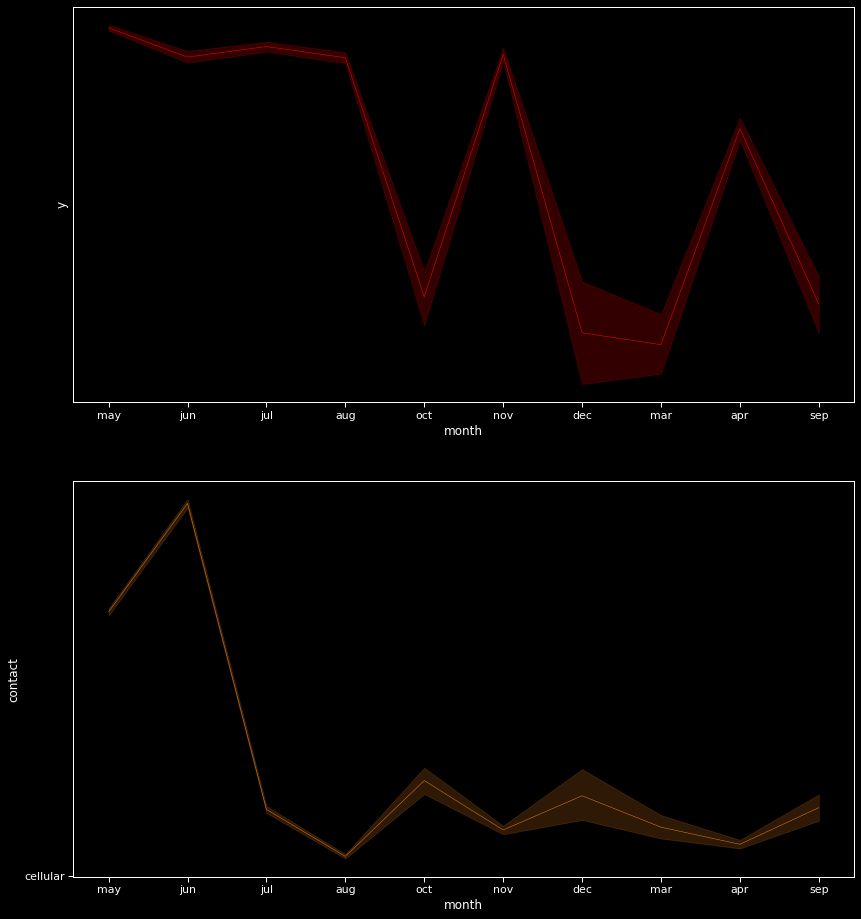

In [21]:
sns.set(style="ticks", context="talk") 
sns.set_context("paper", font_scale = 1.25)
plt.style.use("dark_background")
# contoliing plot size 
fig, axs = plt.subplots(2,1, figsize=(14,16))

sns.lineplot(x = 'month', y ='y', color = '#FF0000', linewidth = 0.5,  data = churn_df, ax=axs[0] )
sns.lineplot(x = 'month', y ='contact', color = '#E67E22', linewidth = 0.5,  data = churn_df, ax=axs[1])
plt.show()

### Feature Engineering Plan

In [22]:
# Apply get dummies for the other columns
names = ['default', 'day_of_week', 'contact', 'pdays', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'nr.employed']
data = pd.get_dummies(data=churn_df, columns=names)


StatementMeta(SparkChurn, 80, 22, Finished, Available)

Add a column with binary variables to be used in the model and change into a pyspark data frame

In [23]:
churn_df['Churn'] = churn_df['y'].map({'yes':1, 'no':0})
churn_df

StatementMeta(SparkChurn, 80, 23, Finished, Available)

       age          job  marital  ... nr.employed    y Churn
0       56    housemaid  married  ...      5191.0   no     0
1       57     services  married  ...      5191.0   no     0
2       37     services  married  ...      5191.0   no     0
3       40       admin.  married  ...      5191.0   no     0
4       56     services  married  ...      5191.0   no     0
...    ...          ...      ...  ...         ...  ...   ...
41183   73      retired  married  ...      4963.6  yes     1
41184   46  blue-collar  married  ...      4963.6   no     0
41185   56      retired  married  ...      4963.6   no     0
41186   44   technician  married  ...      4963.6  yes     1
41187   74      retired  married  ...      4963.6   no     0

[41188 rows x 22 columns]

In [24]:
spark_churn_df = spark.createDataFrame(churn_df)
display(spark_churn_df.groupby('Churn').count())

StatementMeta(SparkChurn, 80, 24, Finished, Available)

SynapseWidget(Synapse.DataFrame, daed0dfa-c9d3-4189-bac5-3420fd184fa8)


/opt/spark/python/lib/pyspark.zip/pyspark/sql/session.py:714: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  'JavaPackage' object is not callable
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.

StatementMeta(SparkChurn, 80, 25, Finished, Available)

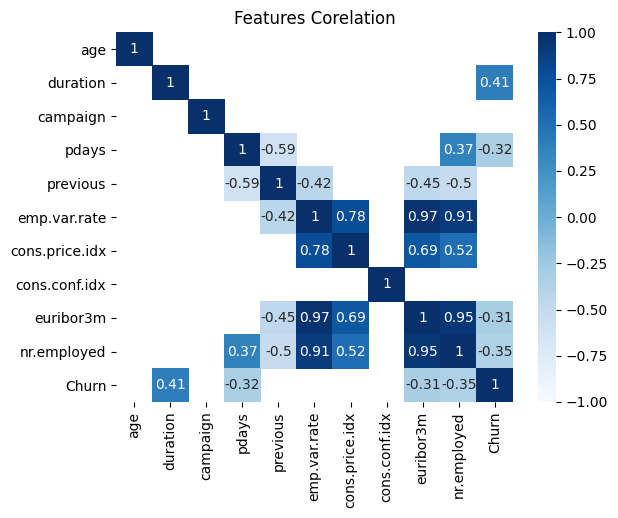

In [25]:
corr = churn_df.corr()
sns.reset_defaults()
sns.heatmap(corr[(corr>0.3)|(corr<-0.3)],vmax=1,vmin=-1,cmap='Blues',annot=True)
plt.title('Features Corelation')
plt.show()

In [34]:
spark_churn_df=spark.createDataFrame(churn_df) 

StatementMeta(SparkChurn, 80, 34, Finished, Available)

## Random Forest Classifier

In [35]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# transformer
vector_assembler = VectorAssembler(inputCols=["Churn"],outputCol="features")
df_temp = vector_assembler.transform(spark_churn_df)
df_temp.show(3)


# drop the original data features column
df = df_temp.drop('Churn')
df.show(3)
from pyspark.ml.feature import StringIndexer


# estimator
l_indexer = StringIndexer(inputCol="contact", outputCol="labelIndex")
df = l_indexer.fit(df).transform(df)
df.show(3)


# data splitting
(training,testing) = df.randomSplit([0.8,0.2])

StatementMeta(SparkChurn, 80, 35, Finished, Available)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+-----+--------+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|Churn|features|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+-----+--------+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|    0|   [0.0]|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|      

In [36]:
# train our model using training data
rf = RandomForestClassifier(labelCol="labelIndex",featuresCol="features", numTrees=10)
model = rf.fit(training)
# test our model and make predictions using testing data
predictions = model.transform(testing)
predictions.select("prediction", "labelIndex").show(5)
# evaluate the performance of the classifier
evaluator = MulticlassClassificationEvaluator(labelCol="labelIndex",predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g " % accuracy)

StatementMeta(SparkChurn, 80, 36, Finished, Available)

+----------+----------+
|prediction|labelIndex|
+----------+----------+
|       0.0|       1.0|
|       0.0|       1.0|
|       0.0|       1.0|
|       0.0|       1.0|
|       0.0|       1.0|
+----------+----------+
only showing top 5 rows

Test Error = 0.363921
Accuracy = 0.636079